<img src="./img/HWNI_logo.svg"/>

# Lab B - Computing and Bootstrapping Correlation

In [1]:
# makes our plots interactive
%matplotlib inline

import numpy as np
import pandas as pd


import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

## Introduction

A technical note: like some previous lab notebooks, this notebook uses the interactive features of JuPyter notebooks. This means that when you generate a plot, you can keep adding things to that plot, so long as you don't either 1) make a new figure or 2) click the blue "power button" in the top-right corner of the figure.

To prevent yourself from accidentally plotting into a figure you didn't mean to plot into, make sure to include a `plt.figure()` in each cell where you're making a plot. You'll want to do this right before you do the plotting commands (`sns.distplot`, `plt.plot`,etc.).

## Computing the Correlation

First, let's generate some correlated data.

The simplest way to generate data that is dependent is to first sample one set of random numbers, then generate another set whose values depend on the first. 

In this example, we create correlated data by first sampling an array of x values from a standard normal and then generating an array of ys by adding another set of random numbers to the xs.

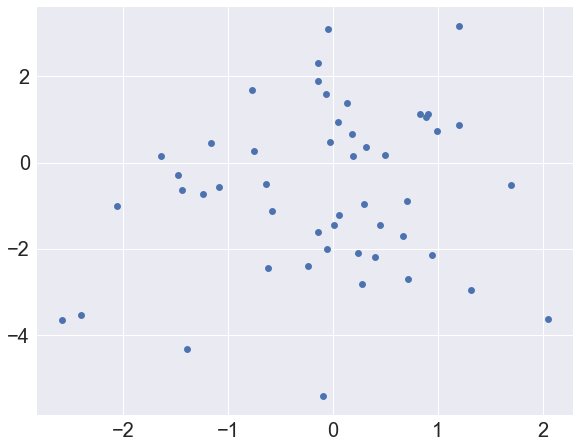

In [2]:
num_points = 50
noise_level = 2

def generate_data(num_points, noise_level):
    xs = np.random.standard_normal(size=num_points)
    ys = np.asarray([x+np.random.standard_normal()*noise_level
                 for x in xs])
    
    return xs,ys

xs,ys = generate_data(num_points,noise_level)

plt.figure()
plt.scatter(xs, ys,
            s=24,linewidth=2);

Python offers a number of options for computing the correlation coefficient of two or more datasets.

### With NumPy

NumPy offers the `corrcoef` function. This function returns a correlation matrix -- the `ij`th entries of this matrix tell you the correlation between the `i`th and `j`th arguments.

#### Q1 What do you expect the correlation coefficient to be when `i == j` (i.e. for the diagonal elements of the matrix)?

<font color="1874CD"> ** It's 1 -- a variable is perfectly correlated with itself! **

Run `corrcoef` below.

In [3]:
np.corrcoef(xs,ys)

array([[ 1.        ,  0.15998658],
       [ 0.15998658,  1.        ]])

Increase the `noise_level` above.

#### Q2 What happens to the  correlation coefficient?

<font color="1874CD"> ** It goes down. **

### With Pandas

Pandas offers a way to calculate the correlation matrix of the numeric columns in a data frame. Data frames have a method, `.corr` that returns the correlation matrix as a data frame.

First, we have to get our data into the pandas `DataFrame` format. Do this in the cell below using `pd.DataFrame.from_dict` or `.from_items`, then calculate the correlation matrix using `data.corr()`.

In [4]:
df = pd.DataFrame.from_items([('x',xs),('y',ys)])
df = pd.DataFrame.from_dict({'x':xs, 'y':ys})

df.corr()

,x,y
x,1.000000,0.159987
y,0.159987,1.000000


### With Seaborn

Seaborn's prime directive is to make things that people do frequently as painless as possible. Since plotting pairs of things and calculating their correlation is a very common step in data analysis, seaborn makes it extremely easy.

Use the function `sns.jointplot` to simultaneously make a scatter plot of the data, calculate the correlation coefficient, and get a bootstrapped $p$-value for the correlation (it's easier than it sounds -- check the tutorial!).

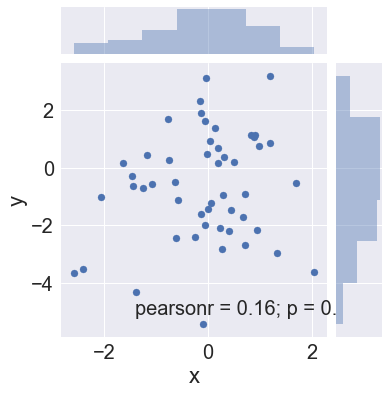

In [5]:
sns.jointplot(data=df, x='x', y='y');

### By "Hand"

We discussed a formula for the correlation coefficient, $r$. It is reproduced below.

$$
r = \frac{1}{n-1} \sum_{i=1}^{n}{\frac{(x_i-\mu_x)}{s_x}
                                  \frac{(y_i-\mu_y)}{s_y}}
$$

where $s_a$ is the estimated population standard deviation of a variable $a$:

$$
s_a = \sqrt{\frac{1}{n-1} \sum_{i=1}^{n}{\left(a_i-\mu_a\right)^2}}
$$

Use this formula to define a function that will compute the correlation coefficient of any pair of random variables, then run that function on our data.
You might be interested in the functions `np.mean` and `np.std`.

In [6]:
def correlate(xs,ys):
    assert len(xs) == len(ys), "arrays must be same size"
    z_scored_xs = z_score(xs)
    z_scored_ys = z_score(ys)
    return np.dot(z_scored_xs, z_scored_ys)/(len(xs)-1)

def z_score(xs):
    mu = np.mean(xs)
    sd = np.std(xs,ddof=1)
    zs = [(x - mu)/sd for x in xs]
    return zs

In [7]:
correlate(xs, ys)

0.15998657927491566

## Getting Confidence Intervals on Correlations with Bootstrapping

In the first half of the lab, we examined the bootstrapping procedure for estimating the sampling distribution of statistics. Now, we'll use that procedure to estimate the sampling distribution of the correlation coefficient.

In the cell below, implement the bootstrap for the correlation coefficient. That is, generate a dataset of size $N$ (aka `num_points`). Then, draw $N$ pairs of `x` and `y` values from the dataset (with replacement) and calculate the correlation coefficient. You can use `np.random.randint(0,len(data))` to generate a random list of indices for sampling with replacement, as shown in the tutorial. Draw pairs from the same dataset at least 1000 times and then plot the distribution of the resulting values with `sns.distplot`.

In [8]:
num_points = 50
noise_level = 2

xs,ys = generate_data(num_points, noise_level)

data = np.asarray([xs, ys]).T #this format is more convenient for bootstrapping

def bootstrap_sample(data):
    # draw N pairs of x and y values
    indices = np.random.randint(0,len(data),size=len(data))
    return data[indices]

def run_bootstrap(data, num_bootstraps):
    #use bootstrap_sample num_bootstraps times,
    # computing the correlation coefficient each time
    rs = np.zeros(num_bootstraps)
    for bootstrap_idx in range(num_bootstraps):
        sample = bootstrap_sample(data)
        rs[bootstrap_idx] = np.corrcoef(sample.T)[0,1]
    return rs

In [9]:
num_bootstraps = 10000
rs = run_bootstrap(data,num_bootstraps)

0.388145603697


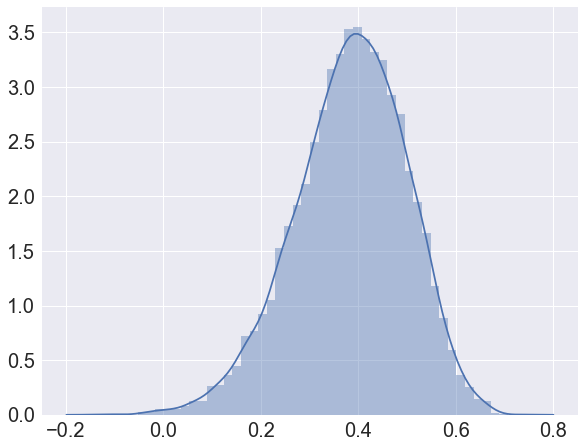

In [10]:
print(correlate(xs, ys))

plt.figure()
sns.distplot(rs);

Given (an approximation to) the sampling distribution, we can calculate a confidence interval at confidence level $1 - \alpha$ by dropping the extreme values of the sampling distribution -- the lower bound of the confidence interval is the $\alpha/2$th percentile of the sampled values and the upper bound of the confidence interval is the $1-\alpha/2$th percentile.

Compute the confidence interval for your correlation coefficient in the cell below. Use, as we do out of habit, $\alpha=0.05$. Hint: look up `np.percentile`. Notice that it takes percentiles as values between 0 and 100, not between 0 and 1!

In [11]:
r = correlate(xs, ys)

def compute_CI(rs, alpha=.05):
    CI = [np.percentile(rs, 100*alpha/2),
          np.percentile(rs, 100*(1-alpha/2))]
    return CI

print(r)
compute_CI(rs)

0.388145603697


[0.14039064770938517, 0.58561766788150615]

If we can compute a confidence interval, we can compute a $p$-value.

#### Q3 Briefly, how would you check if a result is significant at a level $\alpha$ using the set of sampled $r$s?

<font color="1874CD"> ** Check if the null hypothesis is included in the $1-\alpha$ confidence interval. **